# Problem 1 Case 1: Train (Hidden - Output) Weights



Homework 4: Feed-foward Neural Network and Autoencoder Network Modification and Comparison <br>
Due Date: 11/29/22 <br>
Creator: Cat Luong (luongcn@mail.uc.edu)

In [9]:
import random as rand
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 

In [10]:
training_set = np.loadtxt('training_set.txt', dtype=float)
test_set = np.loadtxt('test_set.txt', dtype=float)
np.random.shuffle(training_set)

In [11]:
def get_train_data(training_set): # This function used to get the train data from the training set
    train_data = [list(x[0:784]) for i, x in enumerate(training_set)]
    np_data = np.array(train_data)
    return np_data

def get_labels(training_set): # This function used to get the labels from the training set
    labels = [int(x[-1]) for i, x in enumerate(training_set)]
    np_labels = np.array(labels)
    return np_labels
        

In [12]:
#Parameters initialization
input_neurons = 784 # Corresponds to 28 x 28 image
hidden_neurons = 150 # Between 100 and 200 neurons
output_neurons = 10  # Output numbers from 0 - 9
H, L = 0.75, 0.25 # Operating parameters for threshold such that H > L. If yhat >= H -> 1, yhat <= L -> 0.
learning_rate = 0.001 # initialize learning rate used for calculation of weight change
momentum = 0.5 # Gradient descent with momentum 
bias = 1 # Set bias equal to 1
EPOCHS = 400 # Train on a certain number of EPOCHS

In [13]:
# These are some of the functions I defined to work on the task which are some of the most important 
# The classify() and output() functions are for the winner-takes-all methods
    
def output(y): # Output the index of the entry with the highest value in the output
    max_out = np.amax(y)
    for i, j in enumerate(y): 
            if j == max_out:
                return i

def one_hot_encode(y_labels): # onehot encode the outputs
    one_hot_labels = np.zeros((y_labels.size, output_neurons)) # output_neurons can be y_labels.max() + 1 #int(y_labels.max()) + 1
    one_hot_labels[np.arange(y_labels.size), y_labels] = 1 
    out_hot_labels = one_hot_labels.T
    return one_hot_labels

def error_fractions(y, yhat): # Get the error fraction
    ERRORS = 0
    yhat_one = one_hot_encode(np.int_(classify(yhat)))
    for i, x in enumerate(y):
        for j in range(len(x)):
            if (y[i][j] != yhat_one[i][j]):
                ERRORS += 1
                break
    return (ERRORS/len(y))

def get_EF_digits(confusion_matrix, dataset):
    ERROR_digits = {}
    for i in range(10): 
        correct_pred = float((confusion_matrix[i, i]*10)/len(dataset))
        ERROR_digits[i] = (1.0 - correct_pred)
    return ERROR_digits


def confusion_matrix(y, yhat): # Create a 10 x 10 confusion matrix
    confuse = np.zeros((10,10))
    for i, x in enumerate(y):
                y_output = int(output(y[i]))
                yhat_output = int(output(yhat[i]))
                confuse[y_output][yhat_output] += 1
    return confuse

def classify(y): # Classify to see the output is which number
    output_lst = []
    for o in y:
        max_output = np.amax(o)
        for i, j in enumerate(o): 
            if j == max_output:
                output_lst.append(i)
    return np.asarray(output_lst)

def get_error_digit(y, yhat, digit_list): # Get errors per digit
    error = 0
    for i in digit_list:
        error += (1.0/2.0 * np.sum(((y[i] - yhat[i])**2)))
    return error

def loss_errors(y, yhat): # Get the loss error 
    error = 0.0
    error += (1.0/2.0 * np.sum((y - yhat)**2))
    return error

def get_digits_index(digit, list): # Get the indices of the digits
    indices = []
    for idx, value in enumerate(list):
        if value == digit:
            indices.append(idx)
    return indices

In [14]:
class FNN_Case1():
    def __init__(self, input_neurons, hidden_neurons, output_neurons, learning_rate, momentum, EPOCHS, H, L): 
        self.input_neurons = input_neurons
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.learning_rate = learning_rate
        self.momentum = momentum
        # self.bias1 = np.ones((1, self.hidden_neurons))
        self.bias2 = np.ones((1, self.output_neurons))
        self.epochs = EPOCHS
        self.hidden_layers = 1

        # Threshold values for the output layer when doing forward propagation
        self.H = 0.75
        self.L = 0.25

        # Use as place holders to update weight change
        self.pre_delta_w_1 = 0 
        self.pre_delta_w_2 = 0
    
        # self.Wbar_1 = np.random.randn(self.hidden_neurons, self.input_neurons) * np.sqrt(1 / (self.hidden_neurons + self.input_neurons))
        self.Wbar_1 = np.loadtxt('AE_hidden_weights.txt', dtype=float) # Weights for the (input layer - hidden layer). This is set to the values of the weights from the Autoencoder
        self.Wbar_2 = np.random.randn(self.output_neurons, self.hidden_neurons) * np.sqrt(1 / (self.output_neurons + self.hidden_neurons))# Weights for the hidden layer and the output layers

    def get_weights(self):
        return self.Wbar_1, self.Wbar_2
    
    def get_output(self):
        return self.yhat_2

    def print_weights(self):
        print(f"The first set of weights is: \n{self.Wbar_1=}\n")
        print(f"The second set of weights is: \n{self.Wbar_2=}")

    def mean_weights(self):
        print(f"The mean of final weights 1 is: \n{self.Wbar_1.mean()}\n")
        print(f"The mean of final weights 2 is: \n{self.Wbar_2.mean()}")

    def sigmoid(self, z): # Sigmoid: 1/(1 + e^-x)
        return 1.0/(1.0 + np.exp(-z))

    def deri_sigmoid(self, z): # Derivative of sigmoid
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def ReLU(self, z): # ReLu: max(0, z)
        return np.maximum(0, z)

    def deri_ReLU(self, z): # Derivative of ReLU
        return z > 0

    def forward_prop(self, X): # Define Forward Propagation
        self.z1 = np.dot(X, self.Wbar_1.T) # Net input 1, you don't need bias for this case because the weights are not trained
        self.yhat_1 = self.sigmoid(self.z1) # activation function for the hidden layer
        self.z2 = np.dot(self.yhat_1, self.Wbar_2.T) + self.bias2 #Net input 2 
        self.yhat_2 = self.sigmoid(self.z2) # activation function for the output layer.
                    
    def back_prop(self, X, y, epoch): # Define Back Propagation
        self.threshold()
        self.output_errors = y - self.yhat_2
        
        self.d_output = self.output_errors * self.deri_sigmoid(self.yhat_2)
        self.d_hidden = self.deri_sigmoid(self.yhat_1) * np.dot(self.d_output, self.Wbar_2)

        delta_w_2 = self.learning_rate*np.dot(np.transpose(self.yhat_1), self.d_output) # Weights change for the second layer (hidden - output)
        delta_bias2 =  (self.learning_rate*self.d_output) # Update bias similar to weights

        if(epoch > 1): #run after epoch = 1 according to the lecture
            delta_w_2 += (self.momentum*self.pre_delta_w_2) # => THIS IS TO KNOW HOW THE CHANGES ARE UPDATED
            delta_bias2 += (self.momentum*self.pre_delta_bias2)
            self.Wbar_2 = self.Wbar_2 + delta_w_2.T # for (hidden - output)
            self.bias2 = self.bias2 + np.mean(delta_bias2)

        self.pre_delta_w_2 = delta_w_2 # Keep this value for update of weights change. Do the same for the rest
        self.pre_delta_bias2 = delta_bias2

        
    def threshold(self): #Set threshold for output values. Use during training.
        for q in self.yhat_2:
            for idx, j in enumerate(q):
                if j >= self.H:
                    q[idx] = 1.0
                elif j <= self.L:
                    q[idx] = 0.0
                

In [15]:
X_train = get_train_data(training_set)
y_train = get_labels(training_set)
X_test = get_train_data(test_set)
y_test = get_labels(test_set)

In [16]:
# Initialize the neural network for case 1: 
nn = FNN_Case1(input_neurons, hidden_neurons, output_neurons, learning_rate, momentum, EPOCHS, H, L)

# One hot encode the labels
onehot_ytrain = one_hot_encode(y_train) 
onehot_ytest = one_hot_encode(y_test)

print(X_train.shape)
print(y_train.shape)
print("\n")
print(onehot_ytrain)

(4000, 784)
(4000,)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [17]:
ERROR_train_total = []
ERROR_test_total = []
ERROR_epochs_total = []
# Train the neural network for case 1:
for epoch in range(EPOCHS):
    nn.forward_prop(X_train)
    if (epoch + 1) % 10 == 0:
        print(f"The training set ERROR fraction for epoch {epoch + 1} is: {error_fractions(onehot_ytrain, nn.get_output())}")
        ERROR_train_total.append(error_fractions(onehot_ytrain, nn.get_output()))
        nn.forward_prop(X_test)
        ERROR_test_total.append(error_fractions(onehot_ytest, nn.get_output()))
        nn.forward_prop(X_train)
        ERROR_epochs_total.append(epoch+1)
    nn.back_prop(X_train, onehot_ytrain, epoch)   

C:\Users\Admin\AppData\Local\Temp\ipykernel_19432\853120581.py:40: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


The training set ERROR fraction for epoch 10 is: 0.25
The training set ERROR fraction for epoch 20 is: 0.19325
The training set ERROR fraction for epoch 30 is: 0.17175
The training set ERROR fraction for epoch 40 is: 0.15875
The training set ERROR fraction for epoch 50 is: 0.14925
The training set ERROR fraction for epoch 60 is: 0.141
The training set ERROR fraction for epoch 70 is: 0.1355
The training set ERROR fraction for epoch 80 is: 0.1315
The training set ERROR fraction for epoch 90 is: 0.12925
The training set ERROR fraction for epoch 100 is: 0.128
The training set ERROR fraction for epoch 110 is: 0.1265
The training set ERROR fraction for epoch 120 is: 0.1255
The training set ERROR fraction for epoch 130 is: 0.124
The training set ERROR fraction for epoch 140 is: 0.12275
The training set ERROR fraction for epoch 150 is: 0.121
The training set ERROR fraction for epoch 160 is: 0.12025
The training set ERROR fraction for epoch 170 is: 0.1185
The training set ERROR fraction for epo

## Time Series of Error Fraction

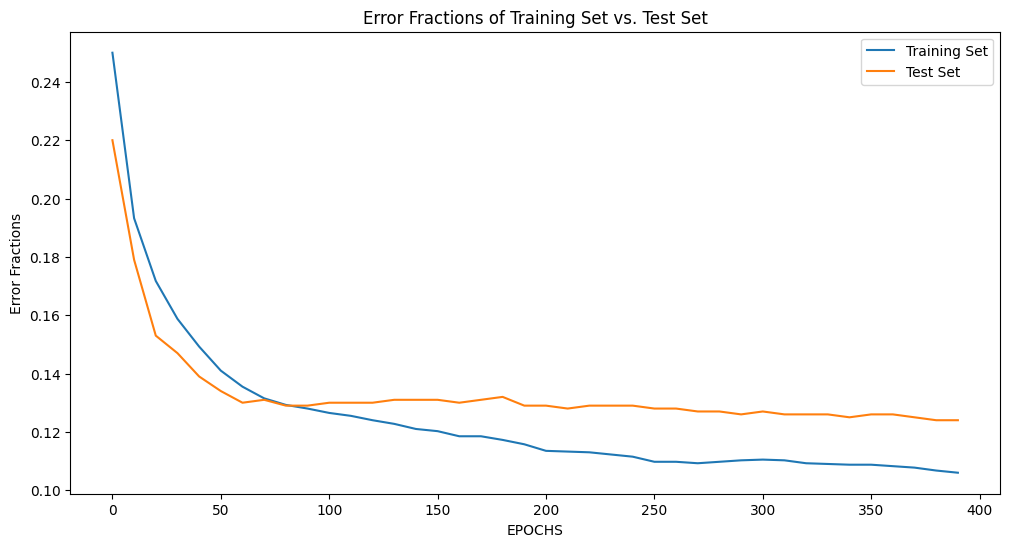

In [18]:
lst_errors = [ERROR_train_total, ERROR_test_total]
labels = ['Training Set', 'Test Set']
fig, axis = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
for i in range(len(lst_errors)):
    plt.plot([i*10 for i in range(len(ERROR_epochs_total))], lst_errors[i], label=labels[i])
plt.title('Error Fractions of Training Set vs. Test Set')
plt.xlabel('EPOCHS')
plt.ylabel('Error Fractions')
plt.legend(loc="upper right")
plt.savefig('problem1_case2_EF.png')
plt.show()

## Create Confusion Matrices

### Training Set

In [19]:
nn.forward_prop(X_train)
train_output = nn.get_output()
train_CM = confusion_matrix(onehot_ytrain, one_hot_encode(np.int_(classify(train_output))))
train_CM

C:\Users\Admin\AppData\Local\Temp\ipykernel_19432\853120581.py:40: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


array([[386.,   0.,   1.,   1.,   0.,   4.,   4.,   2.,   1.,   1.],
       [  0., 390.,   3.,   0.,   1.,   0.,   4.,   1.,   1.,   0.],
       [  7.,   1., 362.,   4.,   3.,   0.,   6.,   6.,   7.,   4.],
       [  0.,   1.,  12., 351.,   1.,   7.,   4.,   6.,  15.,   3.],
       [  1.,   1.,   2.,   1., 347.,   0.,   7.,   2.,   5.,  34.],
       [  4.,   1.,   1.,  14.,   7., 342.,   8.,   1.,  17.,   5.],
       [ 11.,   3.,   2.,   1.,   1.,   3., 375.,   1.,   3.,   0.],
       [  4.,   3.,   8.,   0.,   5.,   1.,   0., 358.,   5.,  16.],
       [  6.,   1.,   8.,  12.,   4.,  26.,   5.,   5., 328.,   5.],
       [  6.,   3.,   3.,   7.,  20.,   3.,   0.,  16.,   5., 337.]])

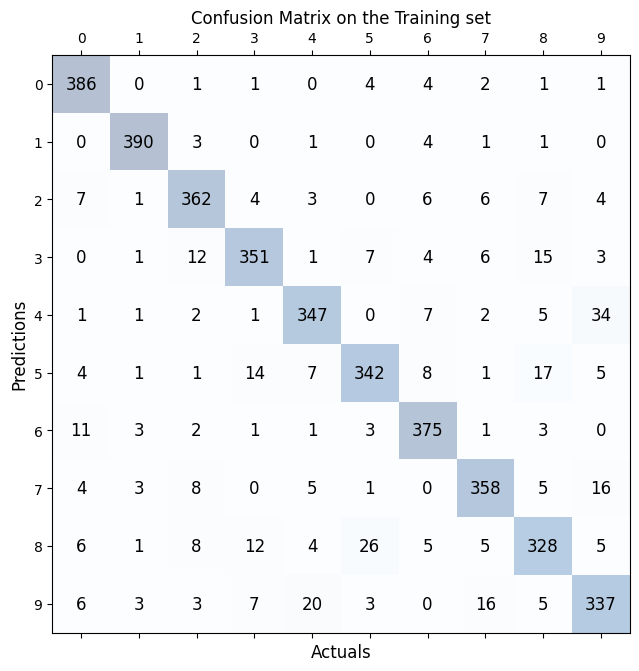

In [20]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(train_CM, cmap=plt.cm.Blues, alpha=0.3)

for i in range(train_CM.shape[0]):
    for j in range(train_CM.shape[1]):
        ax.text(x=j, y=i,s=int(train_CM[i, j]), va='center', ha='center', size='large')

ax.set_xticks(np.arange(len(train_CM), step=1))
ax.set_yticks(list(range(0,len(train_CM))))
plt.xlabel('Actuals', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title('Confusion Matrix on the Training set', fontsize=12)
plt.savefig('problem1_case1_train_CM.png')
plt.show()


### Test Set

In [21]:
nn.forward_prop(X_test)
test_output = nn.get_output()
test_CM = confusion_matrix(onehot_ytest, one_hot_encode(np.int_(classify(test_output))))
test_CM

C:\Users\Admin\AppData\Local\Temp\ipykernel_19432\853120581.py:40: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


array([[96.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.],
       [ 0., 96.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.],
       [ 3.,  0., 84.,  3.,  1.,  0.,  3.,  3.,  3.,  0.],
       [ 0.,  0.,  2., 88.,  0.,  3.,  1.,  2.,  3.,  1.],
       [ 0.,  1.,  1.,  0., 83.,  3.,  5.,  0.,  0.,  7.],
       [ 1.,  0.,  0.,  2.,  0., 90.,  2.,  1.,  2.,  2.],
       [ 3.,  0.,  1.,  1.,  1.,  1., 92.,  0.,  1.,  0.],
       [ 0.,  1.,  2.,  2.,  1.,  0.,  0., 88.,  1.,  5.],
       [ 1.,  2.,  2.,  3.,  2.,  6.,  1.,  2., 79.,  2.],
       [ 3.,  0.,  2.,  0.,  8.,  1.,  0.,  4.,  2., 80.]])

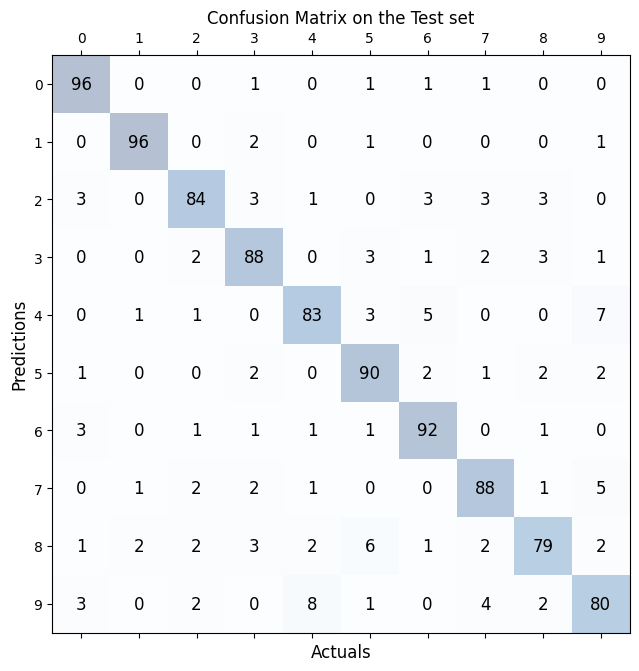

In [22]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(test_CM, cmap=plt.cm.Blues, alpha=0.3)

for i in range(test_CM.shape[0]):
    for j in range(test_CM.shape[1]):
        ax.text(x=j, y=i,s=int(test_CM[i, j]), va='center', ha='center', size='large')

ax.set_xticks(np.arange(len(test_CM), step=1))
ax.set_yticks(list(range(0,len(test_CM))))
plt.xlabel('Actuals', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title('Confusion Matrix on the Test set', fontsize=12)
plt.savefig('problem1_case1_test_CM.png')
plt.show()

## Bar Plots

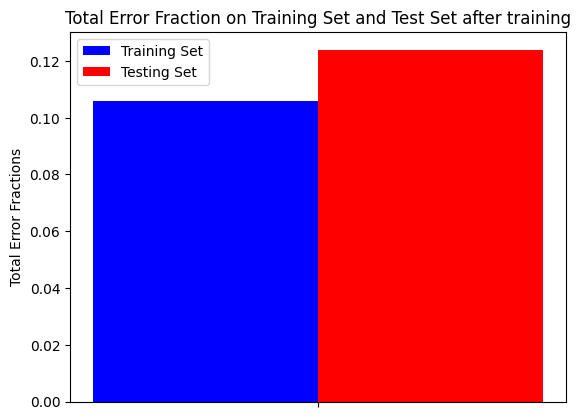

In [23]:
# Calculate optimal width
width = 0.3
indices = np.arange(1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices, ERROR_train_total[-1], width, color='b',label='Training Set',align='edge')
ax.bar(indices + width, ERROR_test_total[-1], width, color='r',label='Testing Set',align='edge')
ax.legend()
ax.set_title('Total Error Fraction on Training Set and Test Set after training')
ax.set_xticks(indices + width, (''))
ax.set_ylabel('Total Error Fractions')
plt.savefig('problem1_case1_EF_total.png')
plt.show()

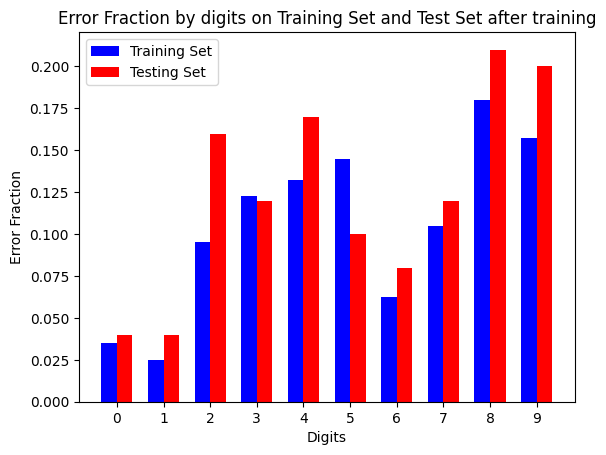

In [24]:
train_EF_digits = get_EF_digits(train_CM, X_train)
test_EF_digits = get_EF_digits(test_CM, X_test)
train = tuple(train_EF_digits.values())
test = tuple(test_EF_digits.values())
indices = tuple(train_EF_digits.keys())

# Calculate optimal width
width = np.min(np.diff(indices))/3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width, train, width, color='b', label='Training Set', align='edge')
ax.bar(indices, test, width, color='r', label='Testing Set', align='edge')
ax.legend()
ax.set_title('Error Fraction by digits on Training Set and Test Set after training')
ax.set_xlabel('Digits')
ax.set_ylabel('Error Fraction')
ax.set_xticks(indices)
plt.savefig('problem1_case1_EF_digits.png')
plt.show()